In [1]:
import numpy as np
import pandas as pd

from sklearn import linear_model
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
%matplotlib inline

import seaborn as sns
sns.set()

# Start Reading Data

In [2]:
#read csv file
portfolio = pd.read_csv('https://goz39a.s3.eu-central-1.amazonaws.com/Portfolio.csv',parse_dates=True,index_col='T')


In [3]:
portfolio.head()

,DAX,NKY,SPX,SX5E,SX7E,SXAP,SXKP,PORTFOLIO
T,,,,,,,,
2014-10-08,-0.00437,-0.00520,0.00752,-0.00408,-0.00456,-0.00751,-0.00297,-0.00325
2014-10-09,0.00047,-0.00327,-0.00907,-0.00155,-0.00464,0.00024,-0.00558,-0.00562
2014-10-14,0.00179,-0.01046,-0.00653,0.00138,0.00075,0.01232,-0.00130,-0.01723
2014-10-15,-0.01265,0.00397,-0.00353,-0.01598,-0.02159,-0.01331,-0.01484,-0.00118
2014-10-16,0.00055,-0.00976,0.00006,-0.00270,-0.00929,0.00638,-0.00521,-0.00183


# Find the futures with the highest Correlation

In [4]:
corr_matrix_sorted = portfolio.corr().abs().sort_values(by='PORTFOLIO',ascending=False)
corr_matrix_sorted['PORTFOLIO']

PORTFOLIO    1.000000
SXKP         0.615897
SX5E         0.580561
SPX          0.568057
SX7E         0.562787
DAX          0.535965
NKY          0.473889
SXAP         0.443584
Name: PORTFOLIO, dtype: float64

Take the 2 indices that are most correlated with the index

In [5]:
futures_names = corr_matrix_sorted['PORTFOLIO'].index[1:3]

In [17]:
print(f'Best Choice :{futures_names}')

Best Choice :Index(['SXKP', 'SX5E'], dtype='object')


In [18]:
X = portfolio.loc[:,futures_names].values
y = portfolio.values[:,-1]


# Train OLS Regression

Set up the ordinary least squares regression (fit_intercept=False)

In [19]:
ols_model = linear_model.LinearRegression(fit_intercept=False)
ols_model.fit(X,y)
coef = ols_model.coef_
intercept = ols_model.intercept_
print('coefficients:',coef)

coefficients: [0.57780642 0.12185669]


# R Squared

In [20]:
print('R Squared:',ols_model.score(X,y))
Y = ols_model.predict(X)

R Squared: 0.3815169055258527


# Graphical Output

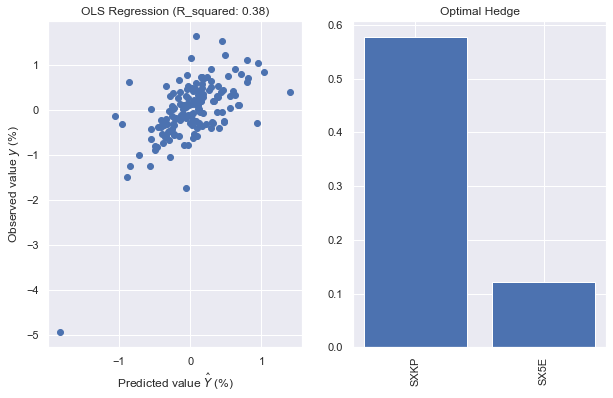

In [21]:
fig , ax = plt.subplots(1,2,figsize=(10,6))
ax[0].scatter(100*Y,100*y)
ax[0].set_xlabel('Predicted value $\hat{Y}$ (%)')
ax[0].set_ylabel('Observed value $y$ (%)')
ax[0].set_title('OLS Regression (R_squared: {v:0.2f})'.format(v=ols_model.score(X,y)))

ax[1].bar(np.arange(0,len(futures_names)),coef)
ax[1].set_xticks(np.arange(0,len(futures_names)))
ax[1].set_xticklabels(futures_names,rotation=90);
ax[1].set_title('Optimal Hedge');

# Other values for Coeffients $\beta$

For different values of $\beta_1$ and $\beta_2$, we are going to evaluate the overall loss $L$. The loss function is defined as the total squared loss.

In [22]:
beta1,beta2 = np.meshgrid(np.arange(-0.6,0.6,0.01),np.arange(-.2,.2,0.01))
L = np.zeros_like(beta1)

In [23]:
def loss(b1,b2,y,X):
    prediction = np.dot(X,np.array([b1 , b2]))
    loss = y - prediction
    mse = loss**2
    return np.sum(mse)

Calculate the loss for the every value in the meshgrid

In [24]:
for i in np.arange(0,beta1.shape[0]):
    for j in np.arange(0,beta1.shape[1]):
        L[i,j] = loss(beta1[i,j],beta2[i,j],y,X)

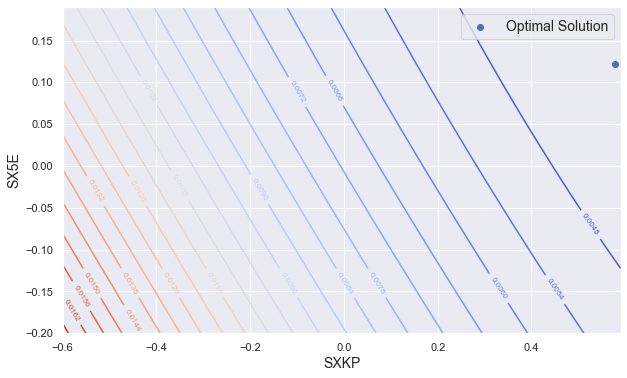

In [14]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
contours= ax.contour(beta1, beta2, L, 20,cmap='coolwarm');
ax.clabel(contours, inline=True, fontsize=8)
ax.scatter(coef[0],coef[1],label='Optimal Solution')
ax.set_xlabel(futures_names[0],fontsize=14)
ax.set_ylabel(futures_names[1],fontsize=14)
ax.legend(loc='best',frameon=True,fontsize=14);